# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                 
Sample_009  P02768                                            29.607
Sample_116  P00740;P00740-2                                   16.629
Sample_104  Q9UJA9                                            16.620
Sample_179  C9JHR8;F5GZZ9;Q86VB7;Q86VB7-2;Q86VB7-3;Q86VB7-4   16.121
Sample_120  P20827                                            17.262
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                        
Sample_054  Q9ULP0-3;Q9ULP0-6                        14.760
Sample_166  A0A075B7B8                               15.237
Sample_063  A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3   13.760
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.780
            A0A075B6Q5                 13.767
            A0A075B6R2                 11.479
            A0A075B6S5                 13.157
            A0A087WSY4                 13.367
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.192
            Q9UI40;Q9UI40-2            13.798
            Q9UIW2                     13.048
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.825
            Q9UP79                     12.852
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.190,15.050,16.842,19.863,15.796,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.754,19.067,...,15.528,15.576,14.075,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.689,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.760,17.705,17.039,16.518,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.859,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.412,15.345,17.084,18.708,14.249,19.433,11.945,10.842
Sample_207,15.739,16.877,15.469,16.898,14.927,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.208,13.634,13.179,13.443,12.795,13.301,12.589,14.214,13.288,13.586
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.639,19.067,16.127,...,13.292,12.373,12.213,13.975,12.648,11.890,13.105,13.184,12.618,12.709
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.757,13.708,12.633,12.964,13.903,12.483,12.151,13.012,13.313,13.269
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.239,13.200,12.185,12.834,11.979,13.092,13.587,13.589,13.894,11.901
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.168,15.029,12.655,13.292,14.114,12.796,12.783,12.560,13.260,13.307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.839,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 317.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.46it/s]

100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.91it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.28it/s]

100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.81it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.53it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.78it/s]

100%|██████████| 5/5 [00:01<00:00,  4.17it/s]

100%|██████████| 5/5 [00:01<00:00,  4.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.51it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.64it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.12it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.95it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.74it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.34it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.99it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.84it/s]

100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.61it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.03it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.36it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.77it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.92it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.89it/s]

100%|██████████| 8/8 [00:01<00:00,  3.97it/s]

100%|██████████| 8/8 [00:01<00:00,  4.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.88it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.99it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.99it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.95it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.77it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.90it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.86it/s]

100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

100%|██████████| 9/9 [00:02<00:00,  3.87it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.86it/s]

 30%|███       | 3/10 [00:00<00:01,  5.10it/s]

 40%|████      | 4/10 [00:00<00:01,  4.26it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.93it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.71it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.83it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.81it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.77it/s]

100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.62it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.19it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.11it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.13it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.83it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.97it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.02it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.98it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.88it/s]

100%|██████████| 11/11 [00:02<00:00,  4.01it/s]

100%|██████████| 11/11 [00:02<00:00,  4.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.09it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.81it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.59it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.49it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.22it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.06it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.02it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.95it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.06it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.08it/s]

100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.11it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.61it/s]

 31%|███       | 4/13 [00:01<00:02,  3.16it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.94it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.77it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.63it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.55it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.55it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.58it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.77it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.06it/s]

100%|██████████| 13/13 [00:04<00:00,  3.39it/s]

100%|██████████| 13/13 [00:04<00:00,  3.00it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.89it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.06it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.10it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.17it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.93it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.54it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.47it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.31it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.87it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.87it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.89it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.94it/s]

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

100%|██████████| 14/14 [00:04<00:00,  3.38it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.05it/s]

 20%|██        | 3/15 [00:00<00:03,  3.77it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.54it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.43it/s]

 40%|████      | 6/15 [00:01<00:02,  3.55it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.68it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.57it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.63it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.82it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.96it/s]

 80%|████████  | 12/15 [00:03<00:00,  4.03it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.16it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.29it/s]

100%|██████████| 15/15 [00:03<00:00,  4.29it/s]

100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.031 0.003          0.780 0.338       0.129   
2             0.003 0.000      0.036 0.003          0.785 0.088       0.714   
3             0.003 0.000      0.035 0.001          0.785 0.100       0.736   
4             0.003 0.000      0.035 0.001          0.804 0.091       0.787   
5             0.003 0.000      0.036 0.002          0.804 0.089       0.786   
6             0.003 0.000      0.035 0.001          0.827 0.079       0.833   
7             0.003 0.000      0.036 0.002          0.829 0.085       0.841   
8             0.003 0.000      0.036 0.003          0.829 0.085       0.832   
9             0.004 0.001      0.039 0.010          0.819 0.082       0.826   
10            0.003 0.000      0.031 0.008          0.818 0.084       0.820   
11            0.004 0.002      0.039 0.014          0.817 0.083       0.815   
12            0.003 0.000      0.035 0.013          0.824 0.087       0.804   
13            0.004 0.004      0.049 0.023          0.822 0.089       0.800   
14            0.005 0.004      0.045 0.016          0.824 0.087       0.806   
15            0.008 0.008      0.060 0.022          0.820 0.082       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.096   0.212 0.142                  0.557 0.047        0.860   
2          0.108   0.742 0.076                  0.783 0.059        0.856   
3          0.113   0.753 0.085                  0.791 0.067        0.884   
4          0.117   0.788 0.076                  0.821 0.063        0.890   
5          0.111   0.789 0.074                  0.821 0.060        0.893   
6          0.104   0.826 0.073                  0.852 0.062        0.917   
7          0.112   0.830 0.076                  0.856 0.064        0.916   
8          0.114   0.825 0.075                  0.851 0.063        0.914   
9          0.104   0.818 0.072                  0.845 0.061        0.917   
10         0.115   0.814 0.077                  0.842 0.065        0.916   
11         0.109   0.811 0.073                  0.840 0.061        0.915   
12         0.100   0.810 0.075                  0.838 0.062        0.924   
13         0.104   0.806 0.077                  0.835 0.064        0.922   
14         0.097   0.811 0.072                  0.838 0.060        0.921   
15         0.097   0.808 0.070                  0.836 0.058        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.831 0.090        210.000 0.000  
2          0.061                  0.817 0.076        210.000 0.000  
3          0.060                  0.857 0.083        210.000 0.000  
4          0.053                  0.863 0.068        210.000 0.000  
5          0.053                  0.865 0.066        210.000 0.000  
6          0.045                  0.898 0.053        210.000 0.000  
7          0.045                  0.898 0.052        210.000 0.000  
8          0.046                  0.896 0.054        210.000 0.000  
9          0.045                  0.900 0.053        210.000 0.000  
10         0.044                  0.898 0.053        210.000 0.000  
11         0.045                  0.897 0.053        210.000 0.000  
12         0.044                  0.912 0.048        210.000 0.000  
13         0.044                  0.910 0.048        210.000 0.000  
14         0.044                  0.909 0.049        210.000 0.000  
15         0.046                  0.906 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 65.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.83it/s]

100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.48it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.33it/s]

100%|██████████| 4/4 [00:00<00:00,  4.48it/s]

100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.56it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.42it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.05it/s]

100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.86it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.30it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.17it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.66it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.17it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.41it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.07it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.92it/s]

100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.78it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.08it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.50it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.57it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.27it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.23it/s]

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

100%|██████████| 8/8 [00:02<00:00,  3.54it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.69it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.14it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.70it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.37it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.20it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.12it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.40it/s]

100%|██████████| 9/9 [00:02<00:00,  3.12it/s]

100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.44it/s]

 30%|███       | 3/10 [00:00<00:01,  4.82it/s]

 40%|████      | 4/10 [00:00<00:01,  4.48it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.07it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.03it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.80it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.79it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.72it/s]

100%|██████████| 10/10 [00:02<00:00,  3.08it/s]

100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.59it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.55it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.23it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.20it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.10it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.00it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.98it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.78it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.83it/s]

100%|██████████| 11/11 [00:02<00:00,  3.35it/s]

100%|██████████| 11/11 [00:02<00:00,  3.85it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.43it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.06it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.29it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.02it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.88it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.82it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.88it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.70it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.68it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.15it/s]

100%|██████████| 12/12 [00:03<00:00,  2.67it/s]

100%|██████████| 12/12 [00:03<00:00,  3.48it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.18it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.46it/s]

 31%|███       | 4/13 [00:01<00:02,  3.10it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.11it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.24it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.39it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.57it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.67it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.59it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.23it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.86it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

100%|██████████| 13/13 [00:04<00:00,  3.18it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.17it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.66it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.14it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.81it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.39it/s]

 50%|█████     | 7/14 [00:01<00:02,  2.96it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.92it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.78it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.63it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.69it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.80it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.66it/s]

100%|██████████| 14/14 [00:04<00:00,  2.62it/s]

100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.41it/s]

 20%|██        | 3/15 [00:00<00:03,  3.65it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.38it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.57it/s]

 40%|████      | 6/15 [00:01<00:02,  3.58it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.48it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.49it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.45it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.47it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.56it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.63it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.63it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.92it/s]

100%|██████████| 15/15 [00:04<00:00,  2.71it/s]

100%|██████████| 15/15 [00:04<00:00,  3.31it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.067 0.029          0.000 0.000       0.000   
2             0.006 0.005      0.060 0.026          0.727 0.126       0.498   
3             0.007 0.005      0.064 0.022          0.727 0.134       0.524   
4             0.004 0.003      0.045 0.015          0.683 0.124       0.527   
5             0.005 0.003      0.047 0.016          0.720 0.087       0.605   
6             0.005 0.004      0.054 0.021          0.767 0.087       0.764   
7             0.006 0.006      0.058 0.022          0.780 0.089       0.778   
8             0.006 0.006      0.060 0.027          0.773 0.094       0.786   
9             0.007 0.006      0.060 0.023          0.768 0.091       0.785   
10            0.005 0.003      0.065 0.027          0.781 0.085       0.787   
11            0.006 0.005      0.069 0.027          0.795 0.085       0.795   
12            0.006 0.006      0.056 0.025          0.797 0.088       0.783   
13            0.006 0.005      0.056 0.023          0.818 0.098       0.791   
14            0.005 0.003      0.057 0.023          0.820 0.097       0.791   
15            0.005 0.004      0.045 0.014          0.813 0.098       0.777   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.862   
2          0.111   0.582 0.096                  0.677 0.062        0.704   
3          0.129   0.598 0.107                  0.687 0.069        0.752   
4          0.126   0.586 0.105                  0.671 0.069        0.751   
5          0.102   0.652 0.074                  0.715 0.053        0.786   
6          0.122   0.760 0.084                  0.796 0.069        0.892   
7          0.126   0.772 0.083                  0.807 0.068        0.893   
8          0.121   0.773 0.083                  0.807 0.070        0.891   
9          0.120   0.771 0.086                  0.804 0.072        0.889   
10         0.126   0.778 0.084                  0.812 0.069        0.891   
11         0.110   0.790 0.075                  0.821 0.063        0.900   
12         0.105   0.785 0.073                  0.817 0.062        0.899   
13         0.119   0.799 0.090                  0.830 0.074        0.917   
14         0.119   0.800 0.089                  0.831 0.073        0.917   
15         0.121   0.788 0.086                  0.821 0.071        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.832 0.087        210.000 0.000  
2          0.083                  0.712 0.088        210.000 0.000  
3          0.074                  0.704 0.098        210.000 0.000  
4          0.072                  0.695 0.094        210.000 0.000  
5          0.064                  0.750 0.087        210.000 0.000  
6          0.053                  0.868 0.063        210.000 0.000  
7          0.054                  0.866 0.067        210.000 0.000  
8          0.053                  0.863 0.066        210.000 0.000  
9          0.055                  0.863 0.064        210.000 0.000  
10         0.052                  0.864 0.061        210.000 0.000  
11         0.051                  0.876 0.060        210.000 0.000  
12         0.051                  0.879 0.059        210.000 0.000  
13         0.046                  0.896 0.055        210.000 0.000  
14         0.046                  0.895 0.056        210.000 0.000  
15         0.047                  0.895 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1090.00it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 30.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.09it/s]

100%|██████████| 3/3 [00:00<00:00, 19.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.17it/s]

100%|██████████| 4/4 [00:00<00:00, 14.52it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.55it/s]

100%|██████████| 5/5 [00:00<00:00, 18.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 26.51it/s]

100%|██████████| 6/6 [00:00<00:00, 18.15it/s]

100%|██████████| 6/6 [00:00<00:00, 18.94it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.99it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.95it/s]

100%|██████████| 7/7 [00:00<00:00, 15.03it/s]

100%|██████████| 7/7 [00:00<00:00, 15.48it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.58it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.68it/s]

100%|██████████| 8/8 [00:00<00:00, 14.82it/s]

100%|██████████| 8/8 [00:00<00:00, 15.57it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.84it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 15.66it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.44it/s]

100%|██████████| 9/9 [00:00<00:00, 15.49it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.60it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.50it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.85it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.32it/s]

100%|██████████| 10/10 [00:00<00:00, 14.29it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.48it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.62it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.74it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.51it/s]

100%|██████████| 11/11 [00:00<00:00, 13.36it/s]

100%|██████████| 11/11 [00:00<00:00, 13.65it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.92it/s]

 33%|███▎      | 4/12 [00:00<00:00, 16.15it/s]

 50%|█████     | 6/12 [00:00<00:00, 13.29it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.23it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.92it/s]

100%|██████████| 12/12 [00:00<00:00, 13.27it/s]

100%|██████████| 12/12 [00:00<00:00, 13.59it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.46it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.58it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.19it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.03it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.83it/s]

100%|██████████| 13/13 [00:00<00:00, 14.09it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 19.83it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.16it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.10it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.51it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.40it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.30it/s]

100%|██████████| 14/14 [00:01<00:00, 10.96it/s]

100%|██████████| 14/14 [00:01<00:00, 11.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 15.48it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.32it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.13it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.38it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.21it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.51it/s]

100%|██████████| 15/15 [00:01<00:00, 11.76it/s]

100%|██████████| 15/15 [00:01<00:00, 12.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.019          0.000 0.000       0.000   
2             0.004 0.003      0.039 0.015          0.645 0.088       0.474   
3             0.004 0.002      0.042 0.015          0.640 0.090       0.478   
4             0.004 0.002      0.045 0.014          0.603 0.101       0.501   
5             0.005 0.004      0.050 0.023          0.594 0.109       0.466   
6             0.004 0.004      0.041 0.015          0.613 0.111       0.471   
7             0.007 0.006      0.071 0.016          0.617 0.092       0.493   
8             0.005 0.004      0.052 0.018          0.605 0.101       0.480   
9             0.005 0.004      0.062 0.026          0.675 0.108       0.567   
10            0.005 0.004      0.046 0.018          0.672 0.110       0.562   
11            0.006 0.005      0.061 0.023          0.658 0.108       0.559   
12            0.006 0.006      0.050 0.024          0.672 0.099       0.593   
13            0.005 0.005      0.054 0.020          0.669 0.107       0.597   
14            0.004 0.002      0.039 0.010          0.691 0.104       0.599   
15            0.009 0.008      0.081 0.040          0.677 0.108       0.592   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.725   
2          0.088   0.542 0.076                  0.641 0.049        0.697   
3          0.089   0.542 0.077                  0.639 0.051        0.695   
4          0.086   0.542 0.077                  0.627 0.062        0.705   
5          0.111   0.516 0.099                  0.616 0.065        0.701   
6          0.105   0.527 0.095                  0.626 0.065        0.696   
7          0.096   0.542 0.079                  0.633 0.056        0.703   
8          0.101   0.528 0.083                  0.622 0.060        0.699   
9          0.121   0.610 0.101                  0.682 0.076        0.784   
10         0.123   0.606 0.104                  0.679 0.077        0.782   
11         0.125   0.598 0.107                  0.673 0.079        0.778   
12         0.114   0.624 0.091                  0.689 0.070        0.781   
13         0.115   0.626 0.098                  0.689 0.078        0.774   
14         0.122   0.635 0.099                  0.700 0.075        0.776   
15         0.117   0.625 0.096                  0.690 0.075        0.773   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.676 0.084        210.000 0.000  
2          0.066                  0.665 0.075        210.000 0.000  
3          0.064                  0.662 0.075        210.000 0.000  
4          0.066                  0.673 0.081        210.000 0.000  
5          0.067                  0.663 0.076        210.000 0.000  
6          0.071                  0.656 0.080        210.000 0.000  
7          0.072                  0.663 0.084        210.000 0.000  
8          0.074                  0.661 0.090        210.000 0.000  
9          0.080                  0.733 0.094        210.000 0.000  
10         0.078                  0.733 0.090        210.000 0.000  
11         0.076                  0.730 0.090        210.000 0.000  
12         0.075                  0.734 0.091        210.000 0.000  
13         0.080                  0.731 0.093        210.000 0.000  
14         0.080                  0.730 0.093        210.000 0.000  
15         0.082                  0.726 0.094 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,9,15
score_time,15,11,15
test_precision,7,14,14
test_recall,7,11,14
test_f1,7,14,14
test_balanced_accuracy,7,14,14
test_roc_auc,12,13,9
test_average_precision,12,13,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.15it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.77it/s]

 31%|███       | 4/13 [00:01<00:02,  3.07it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.55it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.26it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.35it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.42it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.58it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.77it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.65it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.68it/s]

100%|██████████| 13/13 [00:04<00:00,  2.46it/s]

100%|██████████| 13/13 [00:04<00:00,  2.64it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.11it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.80it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.29it/s]

100%|██████████| 9/9 [00:00<00:00, 13.70it/s]

100%|██████████| 9/9 [00:00<00:00, 13.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.50it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.17it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.72it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.16it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.28it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.35it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.23it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.21it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.12it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.27it/s]

100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


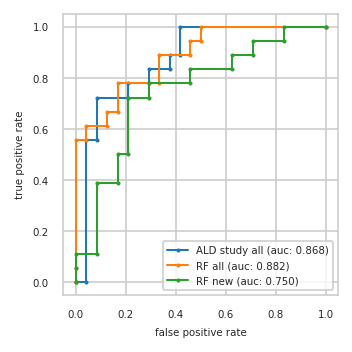

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.556  0.000 0.556  0.000 0.111
3          0.083 0.556  0.042 0.556  0.083 0.111
4          0.083 0.722  0.042 0.611  0.083 0.389
5          0.208 0.722  0.125 0.611  0.167 0.389
6          0.208 0.778  0.125 0.667  0.167 0.500
7          0.292 0.778  0.167 0.667  0.208 0.500
8          0.292 0.833  0.167 0.778  0.208 0.722
9          0.375 0.833  0.333 0.778  0.292 0.722
10         0.375 0.889  0.333 0.889  0.292 0.778
11         0.417 0.889  0.458 0.889  0.458 0.778
12         0.417 1.000  0.458 0.944  0.458 0.833
13         1.000 1.000  0.500 0.944  0.625 0.833
14           NaN   NaN  0.500 1.000  0.625 0.889
15           NaN   NaN  1.000 1.000  0.708 0.889
16           NaN   NaN    NaN   NaN  0.708 0.944
17           NaN   NaN    NaN   NaN  0.833 0.944
18           NaN   NaN    NaN   NaN  0.833 1.000
19           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q13433,I3L3E6;Q658N2,Q9Y490
2,A0A0A0MRJ7;P12259,P04075,P16519;P16519-3
3,P14174,P14174,P04040
4,P61981,P08253,P31321
5,P04075,Q9Y2T3;Q9Y2T3-3,Q9NUQ9
6,Q9Y2T3;Q9Y2T3-3,P61981,Q96GD0
7,Q99983,P15151-2,J3KSJ8;Q9UD71;Q9UD71-2
8,P00338;P00338-3,Q14894,O95497


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


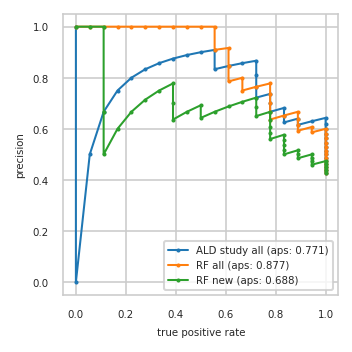

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.593 0.889     0.556 0.833
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.625 0.833     0.667 0.889     0.583 0.778
19         0.652 0.833     0.652 0.833     0.609 0.778
20         0.682 0.833     0.636 0.778     0.636 0.778
21         0.667 0.778     0.667 0.778     0.667 0.778
22         0.700 0.778     0.700 0.778     0.650 0.722
23         0.737 0.778     0.737 0.778     0.684 0.722
24         0.722 0.722     0.778 0.778     0.722 0.722
25         0.765 0.722     0.765 0.722     0.706 0.667
26         0.812 0.722     0.750 0.667     0.688 0.611
27         0.867 0.722     0.800 0.667     0.667 0.556
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.846 0.611     0.846 0.611     0.692 0.500
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.909 0.556     0.909 0.556     0.636 0.389
32         0.900 0.500     1.000 0.556     0.700 0.389
33         0.889 0.444     1.000 0.500     0.778 0.389
34         0.875 0.389     1.000 0.444     0.750 0.333
35         0.857 0.333     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


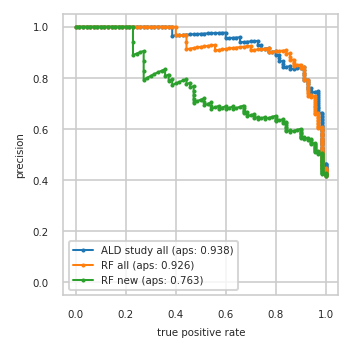

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


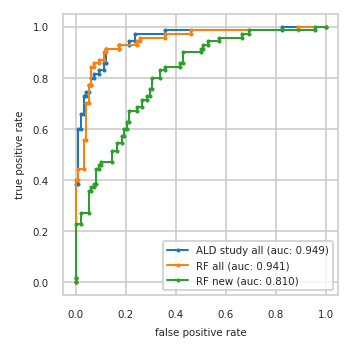

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}